# Linear Weights Prediction

#### Chris Fonnesbeck

Dan's email:

> For the project I mentioned, we’d like you to try to predict pitcher’s linear weights allowed per pitch for September 2016.

> The following link will let you download a dataset of MLB pitches from April 2016 through August 2016 and includes standard pitch details along with the change in run expectancy for the pitch.

> Feel free to use whatever approach you’d like for this – we’re more interested in how you approach the problem than ensuring you followed the same path we did to get there.

> Please don’t spend more than 10 hours of active time on this; we want to get to know how you work, not to extract free work from you.

> If you could send us some material by the end of day on October 6th, that would be great. We’ll set aside some time during your visit to Milwaukee to discuss your response.

I will step through the process that I followed to arrive at my conclusions. Each step, from data import through model fitting, is annotated accordingly.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.gp.util import plot_gp_dist
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/fonnescj/anaconda3/envs/baseball/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data import and cleaning

In [2]:
seasonal_pitch_raw = pd.read_csv('../private_data/seasonal_pitch_data.csv', encoding='utf-8')
seasonal_pitch_raw.head()

year        date bam_game_id  pitcher  \
2016 2016-08-21  2016/08/21/tormlb-clemlb-1      Kluber       Corey   446372   
     2016-04-06  2016/04/06/sfnmlb-milmlb-1  Samardzija        Jeff   502188   
     2016-05-29  2016/05/29/pitmlb-texmlb-1    Barnette        Tony   501817   
     2016-08-11  2016/08/11/colmlb-texmlb-1      Bettis        Chad   518452   
     2016-05-27  2016/05/27/cinmlb-milmlb-1      Morris        A.J.   571963   

                  pitcherid pitcherthrows     batter  batterid batterside  \
2016 2016-08-21  Right              Goins       Ryan    572365   Left       
     2016-04-06  Right             Lucroy   Jonathan    518960   Right      
     2016-05-29  Right          Rodriguez       Sean    446481   Right      
     2016-08-11  Right             Beltre     Adrian    134181   Right      
     2016-05-27  Right             Lucroy   Jonathan    518960   Right      

                pi_pitch_type  horzbreak_corr  inducedvertbreak_corr  \
2016 2016-08-21            CH        16.26790                1.58847   
     2016-04-06            SL        -6.73320               -4.49348   
     2016-05-29            SI        11.93610                9.41389   
     2016-08-11            FA         2.64407               12.64840   
     2016-05-27            FC         0.18483                6.16266   

                 platelocheight  platelocside  relspeed_corr     pitchcall  \
2016 2016-08-21         1.35745     -0.553744      87.480499    BallCalled   
     2016-04-06         3.19904      1.010250      83.077797    BallCalled   
     2016-05-29         3.02771     -0.346645      93.971703  StrikeCalled   
     2016-08-11         2.32722     -1.370810      92.750999    BallCalled   
     2016-05-27         2.32640      0.430191      89.022598  StrikeCalled   

                     lw  
2016 2016-08-21  0.0525  
     2016-04-06  0.0525  
     2016-05-29 -0.0736  
     2016-08-11  0.0525  
     2016-05-27 -0.0736

The data are messed up; name fields contain commas in a comma-separated file so two extra columns are created.

In [3]:
colnames = seasonal_pitch_raw.columns.copy()

In [4]:
seasonal_pitch_raw.iloc[:, 5] = seasonal_pitch_raw.iloc[:, 5] + seasonal_pitch_raw.iloc[:, 6]
seasonal_pitch_raw.iloc[:, 1] = seasonal_pitch_raw.iloc[:, 1] + seasonal_pitch_raw.iloc[:, 2]
seasonal_pitch = (seasonal_pitch_raw.drop(colnames[[2, 6]], axis=1)
                                  .reset_index())
seasonal_pitch.columns = colnames

Clean pitch type column (convert all to upper case)

In [5]:
seasonal_pitch['pi_pitch_type'] = seasonal_pitch.pi_pitch_type.str.upper()

Parse dates to `datetime` types

In [6]:
seasonal_pitch['date'] = pd.to_datetime(seasonal_pitch.date)

In [7]:
seasonal_pitch.head()

,year,date,bam_game_id,pitcher,pitcherid,pitcherthrows,batter,batterid,batterside,pi_pitch_type,horzbreak_corr,inducedvertbreak_corr,platelocheight,platelocside,relspeed_corr,pitchcall,lw
0,2016,2016-08-21,2016/08/21/tormlb-clemlb-1,Kluber Corey,446372,Right,Goins Ryan,572365,Left,CH,16.26790,1.58847,1.35745,-0.553744,87.480499,BallCalled,0.0525
1,2016,2016-04-06,2016/04/06/sfnmlb-milmlb-1,Samardzija Jeff,502188,Right,Lucroy Jonathan,518960,Right,SL,-6.73320,-4.49348,3.19904,1.010250,83.077797,BallCalled,0.0525
2,2016,2016-05-29,2016/05/29/pitmlb-texmlb-1,Barnette Tony,501817,Right,Rodriguez Sean,446481,Right,SI,11.93610,9.41389,3.02771,-0.346645,93.971703,StrikeCalled,-0.0736
3,2016,2016-08-11,2016/08/11/colmlb-texmlb-1,Bettis Chad,518452,Right,Beltre Adrian,134181,Right,FA,2.64407,12.64840,2.32722,-1.370810,92.750999,BallCalled,0.0525
4,2016,2016-05-27,2016/05/27/cinmlb-milmlb-1,Morris A.J.,571963,Right,Lucroy Jonathan,518960,Right,FC,0.18483,6.16266,2.32640,0.430191,89.022598,StrikeCalled,-0.0736


I'm going to discard a few pitch types: 'KN', 'IB', 'XX'

In [8]:
bad_pitches = ~seasonal_pitch.pi_pitch_type.isin(['KN', 'IB', 'XX'])
data_subset = seasonal_pitch[bad_pitches].copy()

So that I can look at patterns at different scales, I will create columns for month, week and day (game).

In [9]:
data_subset['month'] = data_subset.date.dt.month
data_subset['week'] = data_subset.date.dt.week
data_subset['dayofyear'] = data_subset.date.dt.dayofyear

## Data exploration

We can get an idea of some of the best pitches by summing weights across pitcher and pitch type:

In [10]:
data_subset.groupby(['pitcher', 'pi_pitch_type']).lw.sum().sort_values()

pitcher            pi_pitch_type
Scherzer Max       FA              -22.993493
Smyly Drew         FA              -20.935131
Jansen Kenley      FC              -19.185242
Arrieta Jake       SI              -16.048429
Britton Zach       SI              -14.314821
Maeda Kenta        SL              -13.789022
Verlander Justin   FA              -13.088492
Nicasio Juan       FA              -12.631756
Fernandez Jose     CU              -12.463117
McCullers Lance    CU              -12.182173
Hendricks Kyle     SI              -12.054666
Kershaw Clayton    FA              -12.006738
Nolasco Ricky      SL              -11.856740
Hill Rich          FA              -11.705367
Scherzer Max       SL              -11.350651
Koehler Tom        SL              -11.223729
Pomeranz Drew      FA              -11.190345
Giles Ken          SL              -11.169530
Kluber Corey       FC              -10.191713
Kennedy Ian        FA              -10.135644
Familia Jeurys     SI              -10.019600
B

Let's look at Corey Kluber, just to isolate one player:

In [11]:
kluber_pitches = (data_subset.loc[data_subset.pitcherid==446372, 
                                     ['pi_pitch_type', 'month', 'dayofyear', 'lw']]
                      .sort_values(by='lw'))
kluber_pitches.head()

,pi_pitch_type,month,dayofyear,lw
489256,FC,5,152,-0.260061
309350,FA,7,185,-0.257758
171066,FA,4,103,-0.253551
335329,FA,4,120,-0.253235
352719,FC,4,103,-0.251304


About 10 runs saved from his cutter over 5 months:

In [12]:
kluber_pitches[kluber_pitches.pi_pitch_type=='FC'].lw.sum()

-10.191713435559402

If you sum the allowed weights **by month** for each pitch, it gives the impression of a trend, in some instances.

In [13]:
kluber_month_sum = kluber_pitches.groupby(['pi_pitch_type', 'month']).lw.sum().reset_index()

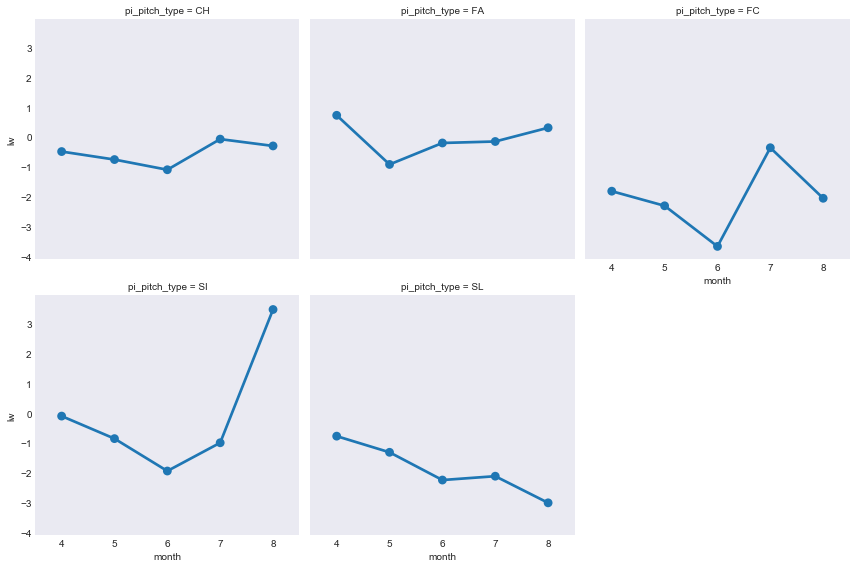

In [14]:
g = sns.factorplot(data=kluber_month_sum, col="pi_pitch_type", x="month", y="lw",
                  col_wrap=3);

However, if you look at the **per-game** observed run values, by summing the weights for each game, the trends mostly disappear.

In [15]:
kluber_game_sum = (kluber_pitches.groupby(['pi_pitch_type', 'dayofyear']).lw
                       .sum().reset_index())

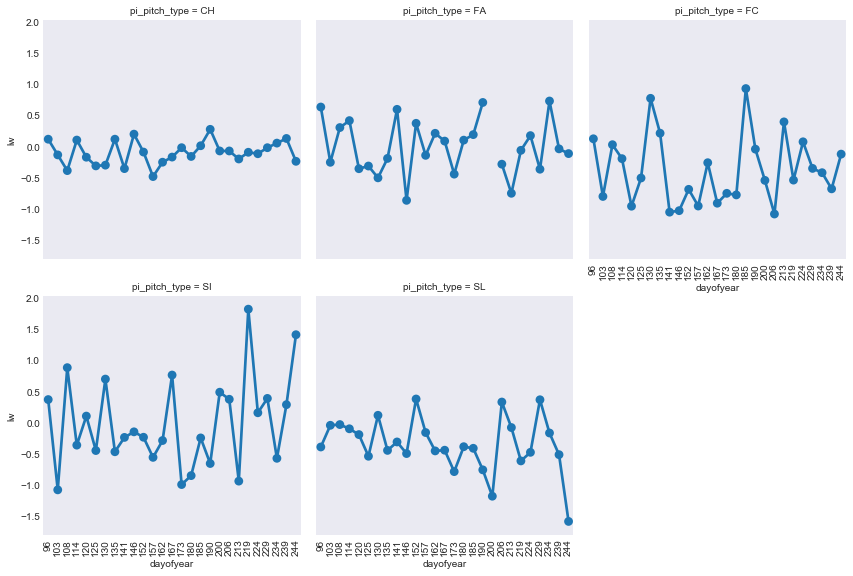

In [16]:
g = sns.factorplot(data=kluber_game_sum, col="pi_pitch_type", x="dayofyear", y="lw",
                  col_wrap=3)
g.set_xticklabels(rotation=90);

If you, take this further and look at the distribution of linear weights allowed per game, you can see the underlying variability in the data. I will proceed with the analysis using the pitch-level data, as the monthly/weekly sums would gloss over the variability associated with those summaries.

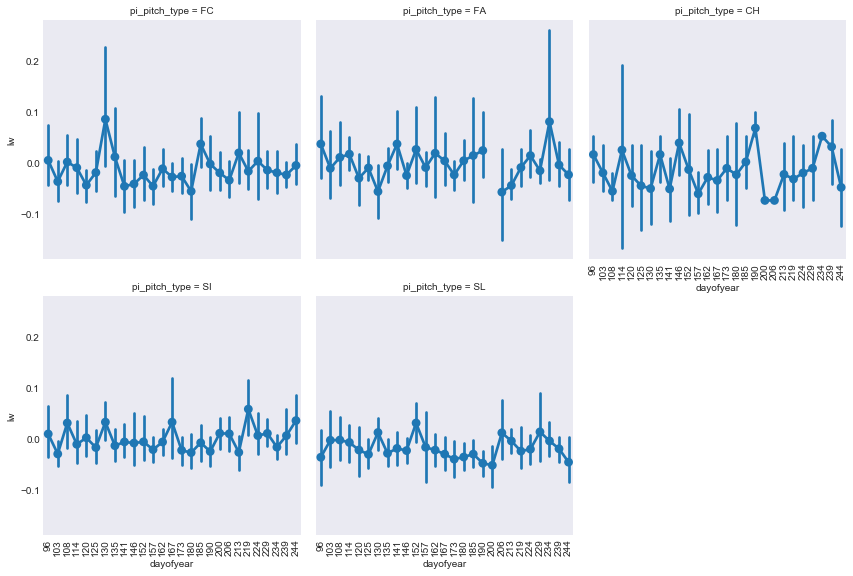

In [17]:
g = sns.factorplot(data=kluber_pitches, col="pi_pitch_type", x="dayofyear", y="lw",
                  col_wrap=3)
g.set_xticklabels(rotation=90);

## Predictive modeling

The question posed suggests a time series prediction problem: predicting the next month's linear weights allowed from the observed weights allowed in the previous 5 months. A conventional approach here might be an ARIMA model, which includes a first-order differencing term and a moving average component. I prefer instead to use a non-parametric Bayesian structural time series approach via Gaussian processes (GP).

A Gaussian process can be viewed as a probabilistic "distribution over functions", which seeks to model the covariance structure of the time series, estimating the degree to which particular observations in the time series are related to those nearby. This seems appropriate here: treating the observed linear weights allowed during each game as a set of Gaussian (this can be relaxed to a different distribution) outcomes, which are correlated with the outcomes from games before and after it. This is another way of saying we have a multivariate Gaussian model. A Gaussian process is just an **infinitely-dimensional** Gaussian, where we may marginalize over any non-observed elements. 

I prefer to build a "data-generating model" based on the observed weights allowed, rather than on the weekly or monthly summaries of the data. I don't expect this to be predictive, but with this approach we may at least be able to characterize the covariance structure and be able to esimate how variable things might look in September.

As an example, let's look at Corey Kluber's slider, but we could easily swap in any player/pitch combination we like:

In [18]:
PITCH = 'SL'

In [19]:
day_min = kluber_pitches.dayofyear - kluber_pitches.dayofyear.min()
day_kluber_fc, lw_kluber_fc = (kluber_pitches.assign(day=day_min)
                .loc[kluber_pitches.pi_pitch_type==PITCH, ['day', 'lw']].T.values)

In [20]:
X = day_kluber_fc.reshape(-1,1)
y = lw_kluber_fc

I'm going to use PyMC3, and open-source Bayesian library for Python that I created many years ago, and continue to develop and maintain today. There are a variety of other Python packages I could have used instead: scikit-learn, Stan, GPFlow, and others. PyMC3 makes it very easy to implement GP models. PyMC lets me specify a GP in just a few lines of code.

Gaussian processes are parameterized by a **mean function** (instead of a mean vector in a multivariate normal) and a **covariance function** (in place of a covariance matrix). The form of the GP is dictated by the covariance function, which can be specified to account for different components of a time series (e.g. periodic). I will use a simple covariance function called the Matérn covariance. Here are a few samples from functions drawn from a Matérn(3/2), just to give an idea:

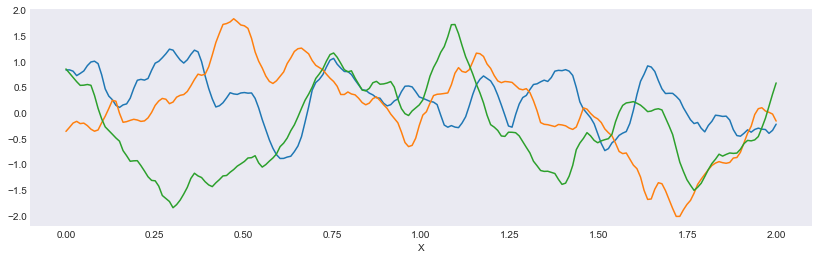

In [21]:
ls = 0.1
tau = 0.5
cov = tau * pm.gp.cov.Matern32(1, ls)

X_vals = np.linspace(0, 2, 200)[:,None]
K = cov(X_vals).eval()

plt.figure(figsize=(14,4))
plt.plot(X_vals, pm.MvNormal.dist(mu=np.zeros(K.shape[0]), cov=K).random(size=3).T);
plt.xlabel("X");

So, this is a flexible covariance function that is parameterized by scale and lengthscale parameters, which will estimate from the data. I will also specify a noise parameter $\sigma$ to characterize the variation of weights allowed within a game.

We will use optimization to obtain the maximum *a posteriori* (MAP) estimate of the model.

In [22]:
with pm.Model() as kluber_model:
    
    # Specify covariance function
    ℓ = pm.Exponential("ℓ", 0.1)
    η = pm.HalfCauchy("η", 1)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    
    # Define marginal GP
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Noise parameter
    σ  = pm.Uniform("σ", 0, 0.3)
        
    # Pass data to marginal likelihood
    ml = gp.marginal_likelihood("ml", X=X, y=y, noise=σ)
    
    mp = pm.find_MAP()


logp = 464.18, ||grad|| = 2.9494: 100%|██████████| 19/19 [00:01<00:00, 13.39it/s]  


Here's an estimate of the standard deviation within days, which looks reasonable compared to the empirical, which is around 0.1.

In [23]:
mp['σ']

array(0.0984857865656092)

The great thing about Gaussian processes is that it is trivial to predict to other points outside the dataset, so we can define a set of points that extends into September, and draw from the conditional distribution:

In [26]:
# new values from April through September
X_new = np.linspace(0, 180, 500)[:,None]

# add the GP conditional to the model, given the new X values
with kluber_model:
    f_pred = gp.conditional("f_pred", X_new)


Here we draw 1000 posterior samples from the predictive GP, to use for inference.

In [27]:
with kluber_model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)

100%|██████████| 1000/1000 [01:31<00:00, 10.90it/s]


The plot below shows the estimated function, along with its uncertainty, which is characterized by many poserior draws from the estimated function. I've also plotted the observed mean of the daily weights allowed each day as a dashed blue line, as well as the per-pitch weights allowed themselves, for which I've specified a shading alpha so that mutliple occurrences of the same weight value appear darker.

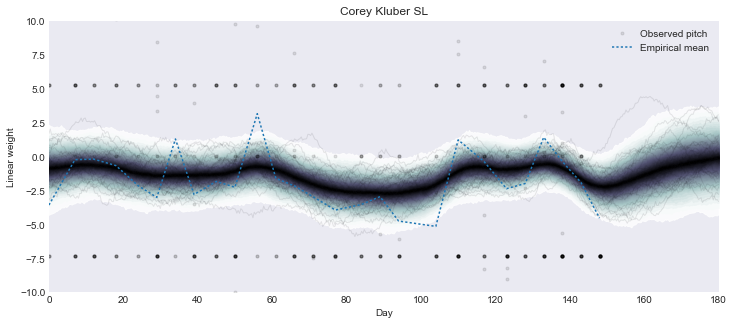

In [28]:
# plot the results
fig, axes = plt.subplots(figsize=(12,5), sharex=True)
scale = 100

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(axes, pred_samples["f_pred"]*scale, X_new, palette="bone_r");

# plot the data alongside the esitmates
axes.plot(X, y*scale, 'ok', ms=3, alpha=0.1, label="Observed pitch");
axes.set_ylim(-0.1*scale, 0.1*scale)
axes.set_title("Corey Kluber {}".format(PITCH))
axes.set_ylabel("Linear weight")

mean_lw = (kluber_pitches[kluber_pitches.pi_pitch_type==PITCH].groupby('dayofyear')
                                                           .lw.mean()*scale)
mean_lw.index = mean_lw.index - mean_lw.index.min()
mean_lw.plot(ax=axes, style=':', label='Empirical mean')

# axis labels and title
plt.xlabel("Day") 
plt.legend()

If we look at the mean of the estimates for days in September, we get:

In [29]:
pred_samples['f_pred'][:, 150:].mean()

-0.014554977154756449

In [30]:
np.percentile(pred_samples['f_pred'][:, 150:], [2.5, 97.5])

array([-0.04294472,  0.01439242])

That is, an estimate `wSL/C` of around -1.5 runs per 100 pitches, with a credible interval of (-4.3, 1.4). 

### Modeling components of variation

A more comprehensive approach involves modeling the components of variation in the time series. A nice property of Gausian processes is that covariance functions are additive, meaning that variation across different scales (in this case, temporal scales) can be modeled directly. 

We can apply this here if, for example, we think there are short-term (the order of a couple games) and medium- or long-term (several weeks or months) components to the variability of particular pitches. Short term variability might involve the effects of a road trip, a minor injury, or other unmeasured factors that could come and go, and which are not particularly predictive. On the other hand, we may be more interested in the variation over a monthly time scale that may reveal the steady development of a pitch, and which may be predictive. Since this is very noisy data, this may be our best hope.

This approach involves using more informative priors, encoding information about the scales we will expect to see the observed weights to vary. Here, we will set the majority of the expected variation for the short term trend to be over a 1-5 game range (via a `gamma(1, 0.75)` prior), while the prior for the long-term lengthscale will cover the 20-60 day range (via a `gamma(20, 0.5)` prior).

It is simple to wrap all of the above in a function, so that it can be applied to other players and pitches:

In [133]:
player_lookup = dict(data_subset[['pitcherid', 'pitcher']].drop_duplicates().values)

def predict_weights(player_id, pitch):
    
    player_pitches = (data_subset.loc[(data_subset.pitcherid==player_id) & (data_subset.pi_pitch_type==pitch), 
                                     ['dayofyear', 'lw']]
                      .sort_values(by='lw'))

    day_min = player_pitches.dayofyear - player_pitches.dayofyear.min()
    day, lw = (player_pitches.assign(day=day_min)[['day', 'lw']].T.values)
    
    X = day.reshape(-1,1)
    y = lw
    
    with pm.Model():
        
        # Short-term variation
        η_short = pm.HalfCauchy("η_short", beta=0.5, testval=0.1)
        ℓ_short = pm.Gamma("ℓ_short", alpha=1, beta=0.75)
        cov_short = η_short**2 * pm.gp.cov.Matern32(1, ℓ_short)
        gp_short = pm.gp.Marginal(cov_func=cov_short)

        # long term trend (1-2 month scale)
        η_trend = pm.HalfCauchy("η_trend", beta=2, testval=2)
        ℓ_trend = pm.Gamma("ℓ_trend", alpha=20, beta=0.5)
        cov_trend = η_trend**2 * pm.gp.cov.ExpQuad(1, ℓ_trend)
        gp_trend = pm.gp.Marginal(cov_func=cov_trend)

        # Define marginal GP
        gp = gp_trend + gp_short

        # Noise parameter
        σ  = pm.Exponential("σ", 10)
        cov_noise = pm.gp.cov.WhiteNoise(σ)

        # Pass data to marginal likelihood
        ml = gp.marginal_likelihood("ml", X=X, y=y, noise=cov_noise)

        mp = pm.find_MAP()
        
        X_new = np.linspace(0, 180, 500)[:,None]
        
        f_pred = gp.conditional("f_pred", X_new)
        pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=1000)
        
    # plot the results
    fig, axes = plt.subplots(figsize=(12,5), sharex=True)
    scale = 100

    # plot the samples from the gp posterior with samples and shading
    plot_gp_dist(axes, pred_samples["f_pred"]*scale, X_new, palette="bone_r");

    # plot the data alongside the esitmates
    axes.plot(X, y*scale, 'ok', ms=3, alpha=0.1, label="Observed pitch");
    axes.set_ylim(-0.1*scale, 0.1*scale)
    axes.set_title("{} {}".format(player_lookup[player_id], pitch))
    axes.set_ylabel("Linear weight")

    mean_lw = player_pitches.groupby('dayofyear').lw.mean()*scale
    mean_lw.index = mean_lw.index - mean_lw.index.min()
    mean_lw.plot(ax=axes, style=':', label='Empirical mean')

    # axis labels and title
    plt.xlabel("Day") 
    plt.legend()
    
    return pred_samples

Here is Trevor Bauer's fastball, as another example. The prediction is smoothed relative to the simpler covariance model.

INFO (theano.gof.compilelock): Refreshing lock /Users/fonnescj/.theano/compiledir_Darwin-17.2.0-x86_64-i386-64bit-i386-3.6.1-64/lock_dir/lock
logp = 243.73, ||grad|| = 0.01387: 100%|██████████| 49/49 [00:02<00:00, 20.14it/s]  
100%|██████████| 1000/1000 [01:08<00:00, 14.62it/s]


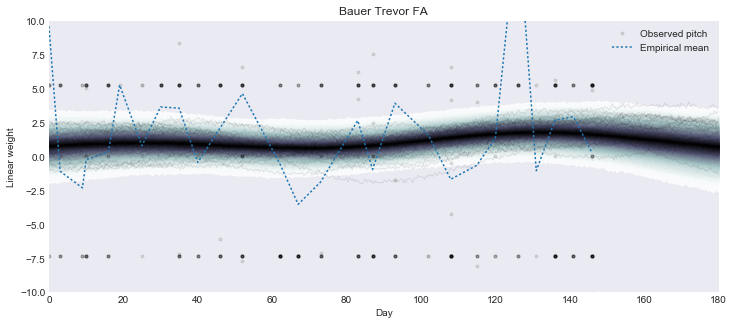

In [137]:
pred_samples = predict_weights(545333, 'FA')

Here are the resulting predictions (mean and 95% interval) for September, shown as `wSI/C`:

In [138]:
pred_samples['f_pred'][:, 150:].mean() * 100

1.2009370578787557

In [139]:
np.percentile(pred_samples['f_pred'][:, 150:], [2.5, 97.5]) * 100

array([-0.91881454,  3.29282994])

## Conclusions

I am not confident that linear weights are predictive, though they are certaintly useful for evaluating how a pitcher/pitch combination fared over some sufficiently long time period. Even though they are adjusted for the count, they are still confounded with many other variables that contributed to the observed outcome: the effects of a particular batter, the pitch combination that preceded the current pitch, the possible influence of the presence of baserunners (was he pitching from the stretch?), and more. I would roughly equate this exercise with trying to predict future stock market returns (another stochastic process) based on past performance. There is serial autocorrelation that may be sometimes predictive over a very short time period, but in general it is not predictive. As with the stock market, we may be able to characterize the temporal variability (volatility) of linear weights allowed, but little more.

As a general approach, however, I like Gaussian processes for robust time series estimation and prediction. Since it is driven by the covariance function, the uncertainty in predictions extrapolated beyond the range of the data is automatically accounted for. The degree to which today's data are predictive of tomorrow's outcome is governed by the covariance function; once these are no longer closely related, the process just reverts to the prior (i.e. what is known in the absence of data). 

## Addendum

Modified from the approach of McShane *et al.* (2011), we can quantify the predictiveness of linear weights using a hierarchical model. I will fit the pitch weights via a population model:

$$lw_{ij} \sim N(\mu + \alpha_i, w_{ij} \sigma^2)$$

where $\mu$ is the population mean and $\alpha_i$ is a random effect corresponding to player $i$ that sum to predict the linear weight for that player in month $j$. 

The partial pooling is governed by the global variance $\sigma^2$, which is weighted for each player-month by the number of times the pitch was thrown relative to the average:

$$w_{ij} = \frac{n_{ij}}{\bar{n}}$$

Finally, the hierarchical random effect $\alpha_i$ is modeled as a zero-inflated mixture that hypothesizes that some subset of players are no different from the population mean for a particular pitch, while others are allowed to vary. Thus, a probability $p$ governs the proportion of players that vary according to $\alpha_i \sim N(0, \sigma_a)$ versus those that are zero (with probability $1-p$).

This model is run for any particular pitch type; I will here use the curveball.

In [72]:
data_summary = (data_subset[data_subset.pi_pitch_type=='CU'].groupby(['pitcher', 'month']).lw
                            .agg([sum, np.size])
                            .reset_index()
                            .rename(columns={'sum': 'weight', 'size': 'n'}))

In [73]:
all_pitchers = data_summary.pitcher.unique()
pitcher_lookup = dict(zip(all_pitchers, np.arange(len(all_pitchers))))
data_summary['pitcher_idx'] = data_summary.pitcher.replace(pitcher_lookup)

In [74]:
# all_pitches = data_summary.pi_pitch_type.unique()
# pitch_lookup = dict(zip(all_pitches, np.arange(len(all_pitches))))
# data_summary['pitch_idx'] = data_summary.pi_pitch_type.replace(pitch_lookup)

In [75]:
data_summary['var_weight'] = data_summary['n'] / data_summary['n'].mean()

In [95]:
y = data_summary.weight.values
w = data_summary.var_weight.values
i = data_summary.pitcher_idx.values

with pm.Model() as hier_weights_curves:
    
    p = pm.Beta('p', 1, 1)
    v = pm.Bernoulli('v', p, shape=len(all_pitchers))
    
    σ_a = pm.HalfCauchy('σ_a', 1)
    η = pm.Normal('η', 0, 1, shape=len(all_pitchers))
    α = pm.Deterministic('α', η*σ_a*v)
    
    μ = pm.Normal('μ', 0, sd=100)
    
    σ = pm.HalfCauchy('σ', 1)
    
    r = pm.Deterministic('r', σ_a / (σ_a + σ))
    
    weight_pred = pm.Normal('weight_pred', μ + α[i], w*σ, observed=y)

In [96]:
with hier_weights_curves:
    trace = pm.sample(1000, tune=2000)

Assigned NUTS to p_logodds__
Assigned BinaryGibbsMetropolis to v
Assigned NUTS to σ_a_log__
Assigned NUTS to η
Assigned NUTS to μ
Assigned NUTS to σ_log__
100%|██████████| 3000/3000 [08:11<00:00,  6.55it/s]/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 4 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))

/Users/fonnescj/Repos/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 2 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


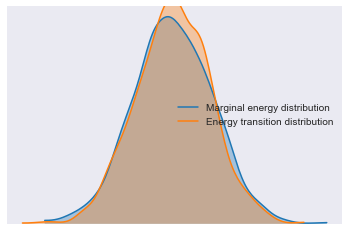

In [97]:
pm.energyplot(trace)

The predictiveness can be characterized by both $p$, which quantifies the proportion players that differ from the league mean, and the proportion of "skill variance" relative to the total variance:

$$r = \frac{\sigma_a}{\sigma_a + \sigma}$$

From the posterior estimates below, we can see that both proportions are low (around 30%), making linear weights not particularly predictive, at least at the monthly scale.

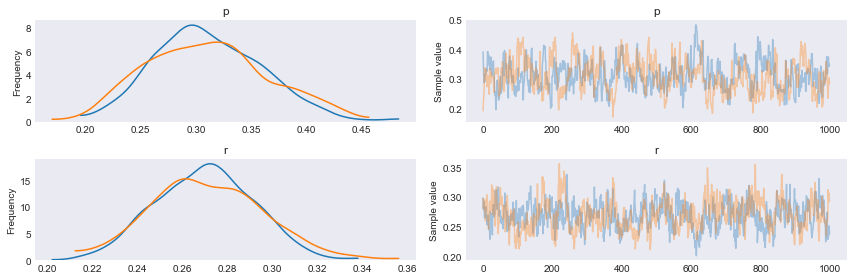

In [99]:
pm.traceplot(trace, varnames=['p', 'r']);

In [101]:
pm.summary(trace, varnames=['p', 'r']).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p,0.311,0.052,0.003,0.219,0.413,149.0,1.000
r,0.270,0.023,0.001,0.226,0.315,171.0,1.001


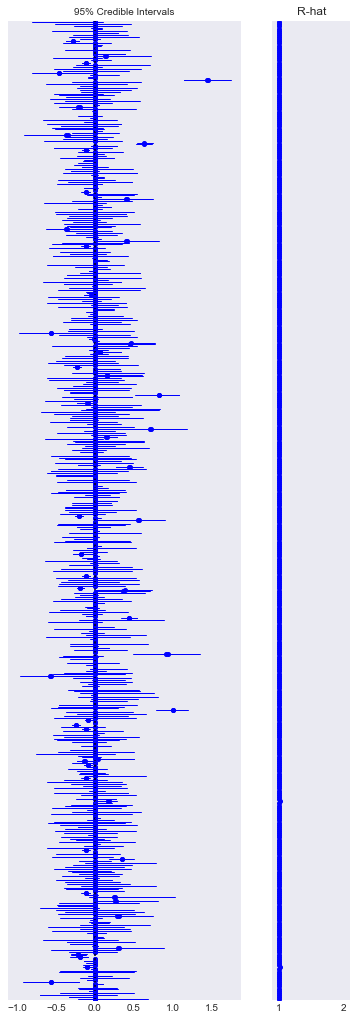

In [106]:
plt.figure(figsize=(5, 16))
pm.forestplot(trace, varnames=['α'], quartiles=False, ylabels=['']);